In [ ]:
# # Load the dataset
# !wget https://data.caltech.edu/records/65de6-vp158/files/CUB_200_2011.tgz?download=1
# !tar -zxvf CUB_200_2011.tgz?download=1

In [ ]:
# Importing libraries
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import random
ROOT = r'../input/cub2002011/CUB_200_2011'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# print(os.listdir('/content/CUB_200_2011'))

In [ ]:
# # Reading the dataset
# from os import walk

# for (path, directory, files) in walk('/content/CUB_200_2011'):
#     print("Directory path: ", path)
#     print("Folder name: ", directory)
# #   print("File name: ", filenames)

In [ ]:
# Define transformations on training and testing data
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1), ratio=(3/4, 4/3)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # mean and std for 3 channels specofic to ImageNet dataset
])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
class BirdData():
    def __init__(self, root, dataset_type='train', transform=None, target_transform=None):

        self.root = root
        self.transform = transform
        self.target_transform = target_transform

        # Load dataframes
        df_img = pd.read_csv(os.path.join(root, 'images.txt'), sep=' ', header=None, names=['ID', 'Image'], index_col=0)
        df_label = pd.read_csv(os.path.join(root, 'image_class_labels.txt'), sep=' ', header=None, names=['ID', 'Label'], index_col=0)
        df_split = pd.read_csv(os.path.join(root, 'train_test_split.txt'), sep=' ', header=None, names=['ID', 'Train'], index_col=0)
        df = pd.concat([df_img, df_label, df_split], axis=1)

        # Relabel
        df['Label'] = df['Label'] - 1

        # Split data
        if dataset_type == 'test':
            df = df[df['Train'] == 0]
        elif dataset_type == 'train':
            df = df[df['Train'] == 1]

        # Extract image names and labels
        self.img_name_list = df['Image'].tolist()
        self.label_list = df['Label'].tolist()

        # Convert greyscale images to RGB mode
        self._convert2rgb()

    def __len__(self):
        return len(self.label_list)


    def __getitem__(self, idx):
        img_path = os.path.join(self.root, 'images', self.img_name_list[idx])
        image = Image.open(img_path)
        target = self.label_list[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            target = self.target_transform(target)
        return image, target

    def _convert2rgb(self):
        for i, img_name in enumerate(self.img_name_list):
            img_path = os.path.join(self.root, 'images', img_name)
            image = Image.open(img_path)
            color_mode = image.mode
            if color_mode != 'RGB':
                # image = image.convert('RGB')
                # image.save(img_path.replace('.jpg', '_rgb.jpg'))
                self.img_name_list[i] = img_name.replace('.jpg', '_rgb.jpg')


In [ ]:
# # Create custom dataset
# class BirdData(Dataset):
#     def __init__(self, root_dir, train, transform=None):
#         self.root_dir = root_dir
#         self.train = train
#         self.transform = transform
#         self._load_data()
#         self.images_dir = '/content/CUB_200_2011/images'


#     def _load_data(self):
#         images_path = os.path.join(self.root_dir, 'CUB_200_2011', 'images.txt')
#         labels_path = os.path.join(self.root_dir, 'CUB_200_2011', 'image_class_labels.txt')
#         split_path = os.path.join(self.root_dir, 'CUB_200_2011', 'train_test_split.txt')

#         print("Images path:", images_path)
#         print("Labels path:", labels_path)
#         print("Split path:", split_path)

#         # Check if files exist
#         for file_path in [images_path, labels_path, split_path]:
#             if not os.path.exists(file_path):
#                 raise FileNotFoundError(f"File not found: {file_path}")

#         images = pd.read_csv(images_path, sep=' ', names=['ID', 'path'], index_col='ID')
#         labels = pd.read_csv(labels_path, sep=' ', names=['ID', 'label'], index_col='ID')
#         split = pd.read_csv(split_path, sep=' ', names=['ID', 'train'], index_col='ID')

#         # Merge dataframes
#         data = pd.concat([images, labels, split], axis=1)

#         # Filtering based on train/test split
#         if self.train:
#             self.data = data.loc[data['train'] == 1]
#         else:
#             self.data = data.loc[data['train'] == 0]

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, index):
#         path, label = self.data.iloc[index]['path'], self.data.iloc[index]['label']
#         img_path = os.path.join(self.root_dir, self.images_dir, path)
#         label -= 1  # Adjust label to start from 0
#         # Open image and convert to RGB
#         image = Image.open(img_path)
#         image = image.convert('RGB')

#         # Applying transformations
#         tensor_image = self.transform(image)
#         return tensor_image, label


In [ ]:
random.seed(42)

# Load dataset
train_data = BirdData(ROOT, 'train', transform=transform_train)
test_data = BirdData(ROOT, 'test', transform=transform_test)

# Data loaders
train_loader = DataLoader(dataset=train_data, shuffle=True, batch_size=32, num_workers=2, drop_last=True)
test_loader = DataLoader(dataset=test_data, batch_size=32, num_workers=2)


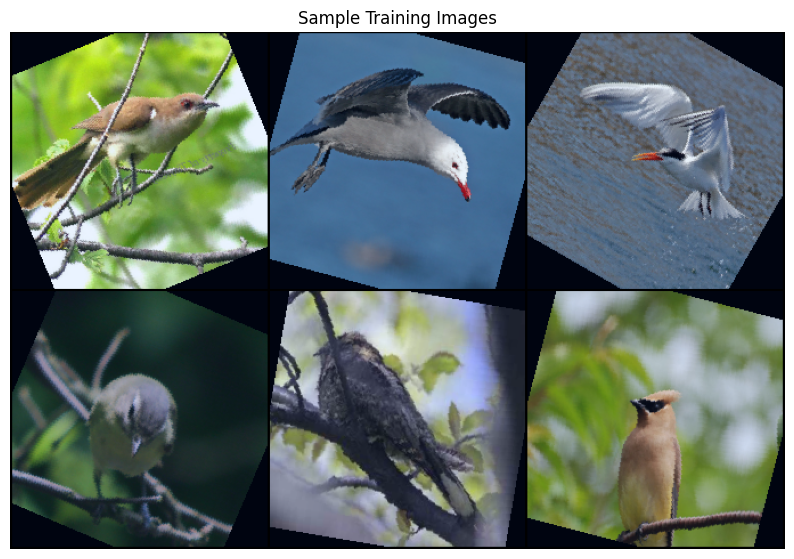

In [ ]:
from torchvision.utils import make_grid

images, labels = next(iter(train_loader))

# Create a grid of images
grid_img = make_grid(images[:6], nrow=3, padding=2, normalize=True)

# Visualize the grid of images
plt.figure(figsize=(10, 8))
plt.title('Sample Training Images')
plt.axis('off')
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

In [ ]:
# Modify the final classifier layer
class CustomClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_prob=0.7):
        super(CustomClassifier, self).__init__()
        self.fc0 = nn.Linear(input_size, hidden_size)
        self.norm0 = nn.BatchNorm1d(hidden_size)
        self.relu0 = nn.ReLU(inplace=True)
        self.dropout0 = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc0(x)
        x = self.norm0(x)
        x = self.relu0(x)
        x = self.dropout0(x)
        x = self.fc1(x)
        return x

# Load pre-trained ShuffleNet model
shufflenet_model = models.shufflenet_v2_x1_0(pretrained=True)
shufflenet_classifier = CustomClassifier(1024, 512, 200)  # Input size adjusted to match ShuffleNet
shufflenet_model.fc = shufflenet_classifier

# Load pre-trained MobileNetV2 model
mobilenet_model = models.mobilenet_v2(pretrained=True)
mobilenet_classifier = CustomClassifier(1280, 512, 200)  # Input size adjusted to match MobileNetV2
mobilenet_model.classifier = mobilenet_classifier

# Define ensemble model
class EnsembleModel(nn.Module):
    def __init__(self, model1, model2):
        super(EnsembleModel, self).__init__()
        self.model1 = model1
        self.model2 = model2

    def forward(self, x):
        x1 = self.model1(x)
        x2 = self.model2(x)
        return (x1 + x2) / 2  # Simple averaging for ensemble

ensemble_model = EnsembleModel(shufflenet_model, mobilenet_model)

# Move the ensemble model to the desired device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ensemble_model.to(device)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to 

EnsembleModel(
  (model1): ShuffleNetV2(
    (conv1): Sequential(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (stage2): Sequential(
      (0): InvertedResidual(
        (branch1): Sequential(
          (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
          (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (4): ReLU(inplace=True)
        )
        (branch2): Sequential(
          (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): Batch

In [ ]:
!pip install torchinfo
from torchinfo import summary

# Assuming your image has 3 channels and size (224, 224)
sample_input = torch.randn(1, 3, 224, 224)  # Batch size 1, 3 channels, 224x224 image

summary(ensemble_model, input_size=sample_input.shape)

Layer (type:depth-idx)                                  Output Shape              Param #
EnsembleModel                                           [1, 200]                  --
├─ShuffleNetV2: 1-1                                     [1, 200]                  --
│    └─Sequential: 2-1                                  [1, 24, 112, 112]         --
│    │    └─Conv2d: 3-1                                 [1, 24, 112, 112]         648
│    │    └─BatchNorm2d: 3-2                            [1, 24, 112, 112]         48
│    │    └─ReLU: 3-3                                   [1, 24, 112, 112]         --
│    └─MaxPool2d: 2-2                                   [1, 24, 56, 56]           --
│    └─Sequential: 2-3                                  [1, 116, 28, 28]          --
│    │    └─InvertedResidual: 3-4                       [1, 116, 28, 28]          7,398
│    │    └─InvertedResidual: 3-5                       [1, 116, 28, 28]          7,598
│    │    └─InvertedResidual: 3-6                    

In [ ]:
# Defining a function for calculating testing accuracy
def accuracy(model, data_loader, N=None):

    correct_predictions = 0
    total_predictions = 0

    # number of samples
    if N == None:
        N = len(data_loader.dataset)

    # determine mode
    training = model.training
    if training:
        model.eval()

    with torch.no_grad():  # Disable gradient calculation during evaluation
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)

            z = model(x)
            _, yhat = torch.max(z.data, 1)
            correct_predictions += (yhat == y).sum().item()
    test_acc = correct_predictions / N

    # switch back to former mode
    if training:
        model.train()

    return test_acc

In [ ]:
def train(model, train_loader, test_loader, optimizer, scheduler, max_epoch=100, test_period=10):  # train with cyclic learning rate; Args: optimizer: optimizer, scheduler: optim.lr_scheduler, test_period (int): period of test

    # Redefine the lists inside the function to avoid accumulation
    training_losses = []
    training_accuracies = []
    testing_accuracies = []

    N_train = len(train_loader.dataset)
    N_test = len(test_loader.dataset)
    best_acc = 0

    # make sure model is in the training mode
    model.train()

    for epoch in range(max_epoch):
        training_loss = 0
        correct_predictions = 0

        # Iterate over the training dataset
        for x, y in train_loader:
            # setting GPU
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()

            # Update training loss
            training_loss += loss.item()
            _, yhat = torch.max(z.data, 1)
            correct_predictions += (yhat == y).sum().item()

        # usual learning rate decay
        epoch_loss = training_loss/len(train_loader)
        training_losses.append(epoch_loss)
        # lrs.append(scheduler.get_last_lr())
        scheduler.step()

        # ! acc on train in train mode
        epoch_accuracy = correct_predictions / N_train
        training_accuracies.append(epoch_accuracy)

        if epoch % test_period == 0:
            testing_accuracy = accuracy(model, test_loader, N_test)
            testing_accuracies.append(testing_accuracy)
            if testing_accuracy > best_acc:
                best_acc = testing_accuracy
            print(f"Epoch [{epoch + 1}/{max_epoch}], Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.4f}, Testing Accuracy: {testing_accuracy:.4f}")

    # final test
    print('\nfinal accuracy')
    print('train: {:.3f}%\ttest: {:.3f}%\tbest on test: {:.3f}%'.format(epoch_accuracy*100, accuracy(model, test_loader)*100, best_acc*100))
    return training_losses, training_accuracies, testing_accuracies

In [ ]:
criterion = nn.CrossEntropyLoss()

# Hyper-parameters
init_lr = 1e-3
weight_decay = 1e-4
max_epoch = 25
test_period = 1

optimizer = optim.AdamW(ensemble_model.parameters(), lr=init_lr, betas=(0.9, 0.999), weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epoch, eta_min=0)  # https://wiki.cloudfactory.com/docs/mp-wiki/scheduler/cosineannealinglr

# Train the model
costs, train_accs, test_accs = train(ensemble_model, train_loader, test_loader, optimizer, scheduler, max_epoch, test_period)
torch.save(ensemble_model.state_dict(), 'ensemble_model.pth')

Epoch [1/25], Training Loss: 4.4747, Training Accuracy: 0.0804, Testing Accuracy: 0.2278
Epoch [2/25], Training Loss: 3.0356, Training Accuracy: 0.2571, Testing Accuracy: 0.3733
Epoch [3/25], Training Loss: 2.3951, Training Accuracy: 0.3707, Testing Accuracy: 0.4669
Epoch [4/25], Training Loss: 2.0173, Training Accuracy: 0.4566, Testing Accuracy: 0.5249
Epoch [5/25], Training Loss: 1.6963, Training Accuracy: 0.5312, Testing Accuracy: 0.5778
Epoch [6/25], Training Loss: 1.4846, Training Accuracy: 0.5794, Testing Accuracy: 0.5872
Epoch [7/25], Training Loss: 1.3121, Training Accuracy: 0.6360, Testing Accuracy: 0.5982
Epoch [8/25], Training Loss: 1.1911, Training Accuracy: 0.6580, Testing Accuracy: 0.6320
Epoch [9/25], Training Loss: 1.0266, Training Accuracy: 0.7002, Testing Accuracy: 0.6426
Epoch [10/25], Training Loss: 0.9213, Training Accuracy: 0.7344, Testing Accuracy: 0.6569
Epoch [11/25], Training Loss: 0.7916, Training Accuracy: 0.7676, Testing Accuracy: 0.6519
Epoch [12/25], Trai

In [ ]:
# Count the number of parameters in the custom classifier
total_params_SN = sum(p.numel() for p in shufflenet_classifier.parameters() if p.requires_grad)
total_params_MN = sum(p.numel() for p in mobilenet_classifier.parameters() if p.requires_grad)

print(f"Total parameters in the shufflenet classifier: {total_params_SN}")
print(f"Total parameters in the mobilenet classifier: {total_params_MN}")

Total parameters in the shufflenet classifier: 628424
Total parameters in the mobilenet classifier: 759496


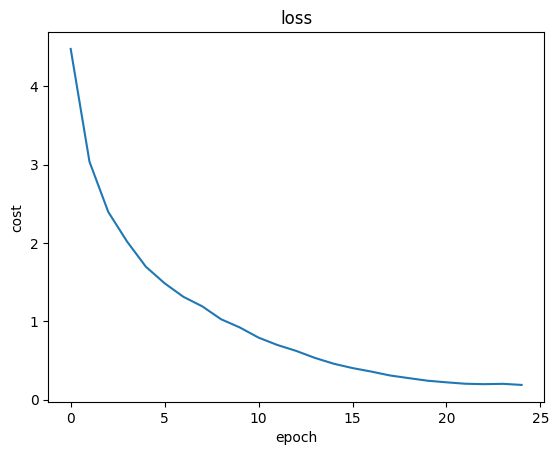

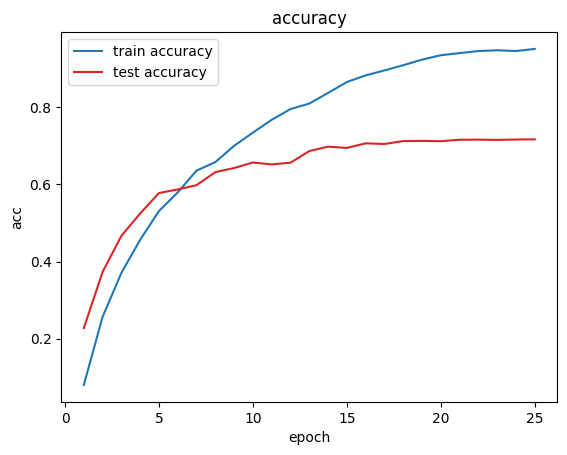

In [ ]:
def draw_cost(costs, title='loss'):
    plt.figure(dpi=100)
    plt.plot(costs)
    plt.xlabel('epoch')
    plt.ylabel('cost')
    plt.title(title)
    plt.show()


def draw_accs(train_accs, test_accs, test_period=test_period, title='accuracy'):
    epochs = test_period * len(test_accs)
    train_accs = train_accs[:epochs]
    x_axis = np.arange(1, epochs+1, test_period).astype(int)
    plt.figure(dpi=100)
    plt.plot(x_axis, train_accs[::test_period], color='tab:blue', label='train accuracy')
    plt.plot(x_axis, test_accs, color='tab:red', label='test accuracy')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.legend()
    plt.title(title)
    plt.show()


draw_cost(costs)
draw_accs(train_accs, test_accs, test_period)

In [ ]:
# # Save the current state of the model, optimizer, and other training-related parameters
# checkpoint = {
#     'epoch': epochs,
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'loss': epoch_loss
#     }

# # Define the file path where you want to save the checkpoint
# checkpoint_path = 'checkpoint.pth'

# # Save the checkpoint
# torch.save(checkpoint, checkpoint_path)

In [ ]:
# # Plot training loss vs epoch
# plt.figure(figsize=(10, 5))
# plt.plot(range(1, epochs + 1), training_losses, label='Training Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Training Loss')
# plt.title('Training Loss vs Epoch')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Plot training accuracy and testing accuracy vs epoch
# plt.figure(figsize=(10, 5))
# plt.plot(range(1, epochs + 1), training_accuracies, label='Training Accuracy')
# plt.plot(range(1, epochs + 1), testing_accuracies, label='Testing Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Training and Testing Accuracy vs Epoch')
# plt.legend()
# plt.grid(True)
# plt.show()
